In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import math
from random import randint, seed
from rasterio.plot import show
from rasterio.windows import Window 
plt.switch_backend('TKagg')
%matplotlib inline

In [152]:
src = rasterio.open('../depth_dDEMs/hv/corrected/hv_depth_107_2012_corrected_0.13_m_trimmed.tif')
width = src.meta['width']
height = src.meta['height']

if width >= height:
    ratio = round(width / height, 2)
else:
    ratio = round(height / width, 2)

print('ratio ', ratio)
fudge = (1 / (ratio))
print('fudge ', fudge)

hlimit = int((height)*fudge)

wlimit = int((width) * (1-fudge))

print(wlimit, hlimit)
print(src.meta)
northing = src.meta['transform'][5] # northing
easting = src.meta['transform'][2] # easting
print(easting, northing)

ratio  4.53
fudge  0.22075055187637968
2649 3399
{'count': 1, 'nodata': -9999.0, 'width': 3400, 'dtype': 'float32', 'height': 15400, 'transform': Affine(1.0, 0.0, 421000.0,
       0.0, -1.0, 7678000.0), 'driver': 'GTiff', 'crs': CRS({'init': 'epsg:32606'})}
421000.0 7678000.0


In [3]:
# Get neat and tidy windows based on common scale factors

def factors(n):
    results = set()
    for i in range(1, int(math.sqrt(n)) + 1):
        if n % i == 0:
            results.add(i)
            results.add(int(n/i))
    return results

xfac = factors(width)
yfac = factors(height)
common_facs = xfac.intersection(yfac)
common_facs.discard(1)
common_facs.discard(2)
common_facs.discard(4)

xy_window_coord_increments = []
for i in list(common_facs):
    x, y = (width / i), (height / i)
    if x > 100 and y > 100 and x != width:    
        xy_window_coord_increments.append([x,y])


In [148]:
# Get random (size and location) 

#seed(2)
win_x_starts = [randint(500, width - 500) for p in range(0, 10)]

#seed(3)
win_y_starts = [randint(500, height - 500) for p in range(0, 10)]

#seed(0)
win_widths = [randint(100, wlimit) for p in range(0, 10)]

#seed(1)
win_heights = [randint(100, hlimit) for p in range(0, 10)]

#print(win_x_starts[0], win_y_starts[0])
#print(win_widths[0], win_heights[0])
win_x_stops =[sum(x) for x in zip(win_x_starts, win_widths)]
win_y_stops = [sum(y) for y in zip(win_y_starts, win_heights)]
#print(win_x_stops[0], win_y_stops[0])

aoi_windows = list(zip(zip(win_y_starts, win_y_stops), zip(win_x_starts, win_x_stops)))

print(len(aoi_windows), ' AOI windows were generated...')

culled_aois = [s for s in aoi_windows if s[0][1] <= height and s[1][1] <= width]

print(len(culled_aois), ' AOI windows are valid...')
print('((row_start, row_stop), (col_start, col_stop))')
for a in culled_aois:
    print(a)


10  AOI windows were generated...
6  AOI windows are valid...
((row_start, row_stop), (col_start, col_stop))
((8824, 10208), (718, 3364))
((13004, 14834), (906, 1988))
((6337, 9415), (2428, 2960))
((9528, 11046), (653, 3056))
((4938, 6076), (502, 2067))
((9809, 12472), (955, 1531))


In [153]:
start_coords = [(i[0][0], i[1][0]) for i in culled_aois]
start_coords = [i[::-1] for i in start_coords]
for c in start_coords:
    print(c)
utm_start_coords = [(i[0] + easting , northing - i[1]) for i in start_coords]
for c in utm_start_coords:
    print(c)
#start_coords

(718, 8824)
(906, 13004)
(2428, 6337)
(653, 9528)
(502, 4938)
(955, 9809)
(421718.0, 7669176.0)
(421906.0, 7664996.0)
(423428.0, 7671663.0)
(421653.0, 7668472.0)
(421502.0, 7673062.0)
(421955.0, 7668191.0)


In [154]:
vals = [a for a in src.sample(utm_start_coords)]
vals

[array([nan], dtype=float32),
 array([nan], dtype=float32),
 array([0.37491822], dtype=float32),
 array([nan], dtype=float32),
 array([nan], dtype=float32),
 array([nan], dtype=float32)]

In [164]:
[a for a in vals if sum(a) > 0]

# we can now get sample values from the src?
# use indices of not nan sample values to filter windows?
# figure out how to filter list of aoi windows using the list of src sample values

[array([0.37491822], dtype=float32)]

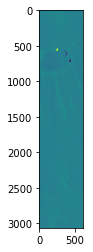

In [142]:
a = src.read(1, window=culled_aois[1])
a
plt.imshow(a)

In [ ]:
d = dict()

for i in xy_window_coord_increments:
    area = str(round(i[0] * i[1] / 1000000, 2)) + ' sq. km'
    
    d[area] = {}
    
    d[area]['x step'] = int(i[0])
    d[area]['y step'] = int(i[1])
    d[area]['x starts'] = [int(a) for a in np.arange(0, width, i[0])]
    d[area]['y starts'] = [int(a) for a in np.arange(0, height, i[1])]
    #d[area]['offs'] = [a for a in zip(d[area]['x starts'], d[area]['y starts'])]
    
    d[area]['neat_windows'] = {}
    
    j = 0
    
    while j < len(d[area]['y starts']):
        array_tag = 'neat_array_' + str(j+1)
        d[area]['neat_windows'][array_tag] = {}
        d[area]['neat_windows'][array_tag]['bounds'] = Window(d[area]['x starts'][j-1],
                                                         d[area]['x starts'][j-1],
                                                         d[area]['x step'],
                                                         d[area]['y step'])
        d[area]['neat_windows'][array_tag]['depth'] = src.read(1, window=d[area]['neat_windows'][array_tag]['bounds'],
                                                         masked=True)

        j += 1
    


In [40]:
d_random = {}

p = 0

for k in filtered_list:

    x,y,w,h = k
    array_tag = 'random_array_' + str(p+1)
    
    d_random[array_tag] = {}

    p += 1
    #area = str(round(x * y / 1000000, 2)) + ' sq. km'
    
    d_random[array_tag]['bounds'] = Window(x,y,w,h)
    d_random[array_tag]['depth'] = src.read(1, window=d_random[array_tag]['bounds'], masked=True)
    d_random[array_tag]['area'] = d_random[array_tag]['depth'].shape[0]*d_random[array_tag]['depth'].shape[1]/1000000

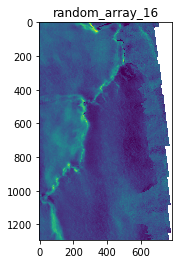

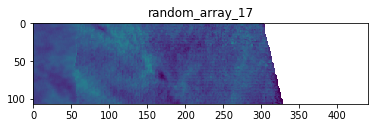

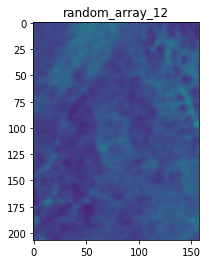

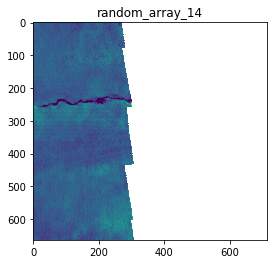

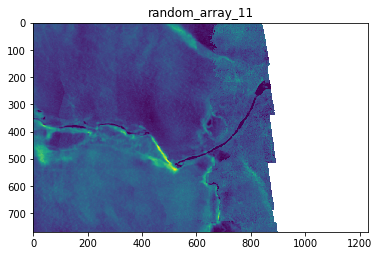

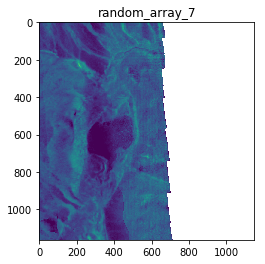

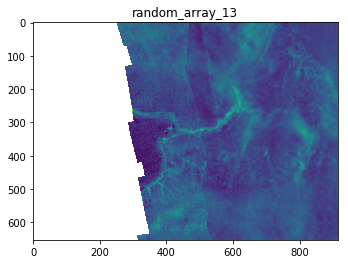

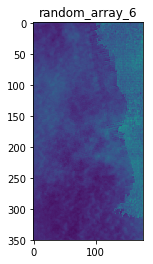

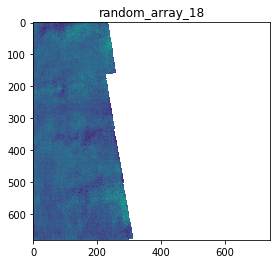

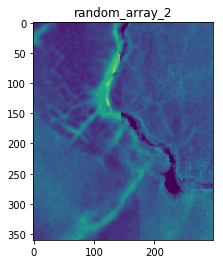

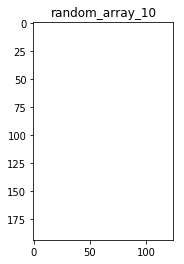

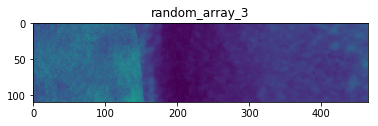

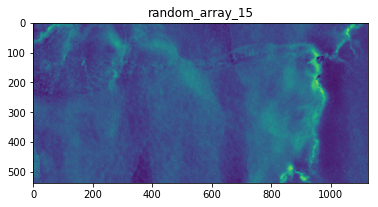

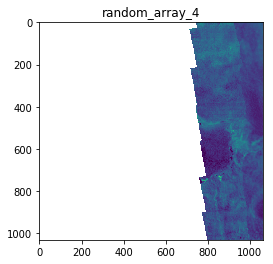

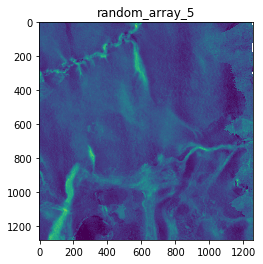

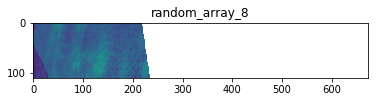

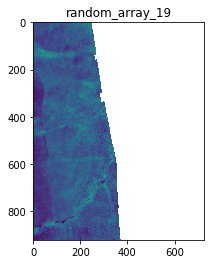

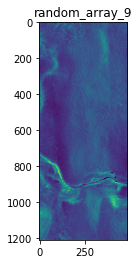

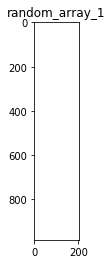

In [41]:
for x in d_random.keys():
    plt.figure()
    plt.title(x)
    plt.imshow(d_random[x]['depth'], vmin=0, vmax=2)

In [ ]:
type(x)

In [ ]:
tiles = [x for x in d_random.values() if type(x)]

In [ ]:
d.values()
#[a for a in d.values() if a == 'windows']

# all_windows = win for win in d.keys().values()

# d[chunk]['array_tag'] = 'array_' + str(win)
#         d[chunk][array_tag] = 'foo' 
#         i += 1
        
# d 
        #;w = src.read(1, window=win, mask=True)
        #d[chunk]

#w = src.read(1, window=Window(0, 0, 1024*2, 1024*3))

In [ ]:
show(w)

In [ ]:
w.max()